# Images Clustering with Sentence Transformers

SentenceTransformers provides models that allow to embed images and text into the same vector space. This allows to find similar images as well as to implement image search or image clustering. 

In this example we will try to **generate clusters based on the images similarity**. **Clustering is an unsupervised machine learning algorithm** that we can use also on images.

**SentenceTransformers** provides a wrapper for the **OpenAI CLIP Model**, which was trained on a variety of (image, text)-pairs.

https://www.sbert.net/examples/applications/image-search/README.html

In this example we will try to cluster some images using sentence transformers which is an Open AI wrapper.
We will use these flowers images available from here:
https://www.kaggle.com/datasets/imsparsh/flowers-dataset

## 1. Settings

In [1]:
#!pip install sentence_transformers

In [2]:
#!pip install ftfy

In [4]:
import glob
import torch
import os
import time
import datetime
import sys
import random
import platform
import socket
import re
import uuid
import json
import psutil
import logging
from matplotlib import pyplot as plt

from PIL import Image
from IPython.display import display
from IPython.display import Image as IPDImage
from tqdm.autonotebook import tqdm

from sentence_transformers import SentenceTransformer, util

In [5]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [6]:
print(datetime.datetime.today())

2022-10-03 14:32:37.797116


In [7]:
def getSystemInfo():
    """
    Get system information
    """
    try:
        info = {}
        info['Platform'] = platform.system()
        info['Platform-release'] = platform.release()
        info['Platform-version'] = platform.version()
        info['Architecture'] = platform.machine()
        info['Hostname'] = socket.gethostname()
        info['IP-address'] = socket.gethostbyname(socket.gethostname())
        info['MAC-address'] = ':'.join(
            re.findall('..', '%012x' % uuid.getnode()))
        info['Processeur'] = platform.processor()
        info['RAM'] = str(round(psutil.virtual_memory().total /
                                (1024.0**3))) + " Gb"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)


json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1077-azure',
 'Platform-version': '#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022',
 'Architecture': 'x86_64',
 'Hostname': 'standardd13',
 'IP-address': '127.0.0.1',
 'MAC-address': '60:45:bd:90:9b:99',
 'Processeur': 'x86_64',
 'RAM': '55 Gb'}

## 2. Images

In [8]:
img_folder = 'flowers'

In [9]:
nbfiles = sum(len(files) for _, _, files in os.walk(img_folder))
print("Number of files in the directory", img_folder, "=", nbfiles)

Number of files in the directory flowers = 2747


In [10]:
imageslist = [
    file for file in glob.glob(img_folder + '/*.*')
    if file.endswith(('jpeg', 'png', 'jpg', 'JPEG', 'PNG', 'JPG'))
]

In [11]:
len(imageslist)

2745

### Let's view some images

In [13]:
def imageView(index, width=250):
    """
    Simple function to display an image from a list
    """
    print("Image file:", imageslist[index])
    display(IPDImage(imageslist[index], width=width))

Image file: flowers/flower (1089).jpg


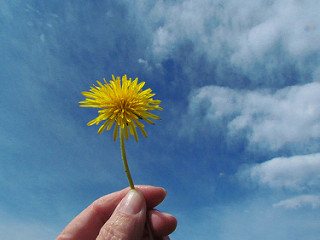

In [14]:
imageView(100)

Image file: flowers/flower (1179).jpg


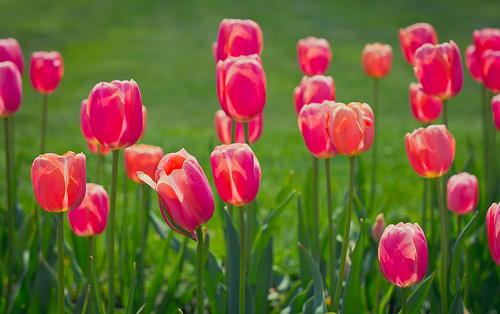

In [15]:
imageView(200)

Image file: flowers/flower (1269).jpg


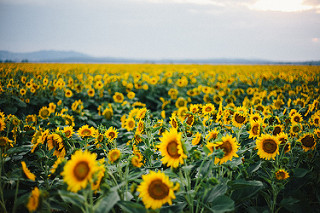

In [16]:
imageView(300)

Image file: flowers/flower (1359).jpg


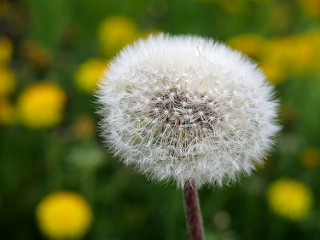

In [17]:
imageView(400)

Image file: flowers/flower (19).jpg


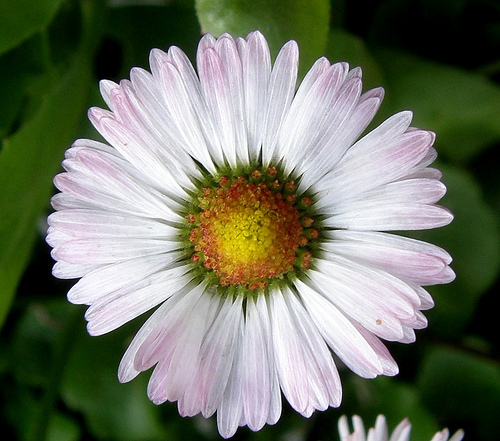

In [18]:
imageView(1000)

Image file: flowers/flower (779).jpg


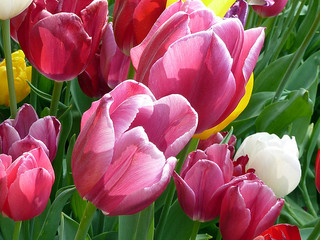

In [19]:
imageView(2500)

## 3. Model specification and Images embedding

Now we can specify a CLIP model to use and we will apply it to all our images
- https://www.sbert.net/docs/pretrained_models.html#image-text-models
- https://huggingface.co/sentence-transformers/clip-ViT-B-32

In [20]:
clipmodel = 'clip-ViT-B-32'

model = SentenceTransformer(clipmodel)
print("We will use model:", clipmodel)

We will use model: clip-ViT-B-32


### Now it is time to process all the images

In [21]:
print("Processing images using", clipmodel, "...")

t1 = time.time()

image_emb = model.encode([Image.open(filename) 
                          for filename in imageslist],
                          batch_size=64,
                          convert_to_tensor=True,
                          show_progress_bar=True)

# For multi process GPU
#pool = model.start_multi_process_pool()
#image_emb = model.encode_multi_process(
#    [Image.open(filename) for filename in imageslist], pool)
#model.stop_multi_process_pool(pool)

print("\nDone in", round((time.time() - t1) / 60, 2), "min.")

Processing images using clip-ViT-B-32 ...


Batches:   0%|          | 0/43 [00:00<?, ?it/s]


Done in 3.49 min.


In [22]:
# Checking if all images have been processed

print("Number of images =", len(imageslist))
print("Number of processed images =", len(image_emb))

Number of images = 2745
Number of processed images = 2745


In [23]:
def imagesClustering(embeddings, threshold, min_cluster_size, init_max_size):

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_cluster_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_clusters = []

    for i in range(len(top_k_values)):

        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size,
                                                              largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:

                for idx, val in zip(top_idx_large, top_val_large):

                    if val < threshold:
                        break

                    new_cluster.append(idx)

            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):

                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_clusters.append(new_cluster)

    # Largest cluster first
    extracted_clusters = sorted(extracted_clusters,
                                key=lambda x: len(x),
                                reverse=True)

    # Step 2) Remove overlapping communities
    unique_clusters = []
    extracted_ids = set()

    for cluster in extracted_clusters:
        add_cluster = True

        for idx in cluster:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_clusters.append(cluster)

            for idx in cluster:
                extracted_ids.add(idx)

    return unique_clusters

In [24]:
def getImagesClusters(image_emb, threshold, min_cluster_size, init_max_size):

    global clusters
    t1 = time.time()
    print("\033[1;31;34mComputing images clusters...\n")

    # Calling the clustering function
    clusters = imagesClustering(embeddings=image_emb,
                                 threshold=threshold,
                                 min_cluster_size=min_cluster_size,
                                 init_max_size=init_max_size)

    # Getting the number of clusters
    nb_clusters = len(clusters)
    print("Total number of clusters =", nb_clusters)

    print("\n\033[0mDone in", round(time.time() - t1, 2), "seconds")

    return nb_clusters

In [41]:
def viewImagesClusters(n_largest_clusters, nb_images_display, width=200):

    cluster_id = idx = 1
    nbimages = 0
    valueslist = []
    labellist = []

    print("Viewing images clustering results:\n")

    # For each cluster let's display the number of images and its %
    for cluster in clusters[0:n_largest_clusters]:
        pctcluster = round(len(cluster) / len(imageslist) * 100, 2)
        print("\033[1;31;34mCluster", idx, "=", len(cluster), "images\t",
              pctcluster, "%")
        label = "cluster " + str(idx) + " : " + str(
            len(cluster)) + " images (" + str(pctcluster) + " %)"
        labellist.append(label)
        valueslist.append(len(cluster))

        nbimages += len(cluster)
        idx += 1

    fig = plt.figure(figsize=(3, 3))
    plt.pie(valueslist, labels=labellist)
    plt.title("Number of images per cluster")
    plt.show()

    print("\nTotal number of images in these clusters =", nbimages, "images",
          round(nbimages / len(imageslist) * 100, 2), "%")

    # For each cluster let's display some images to check the quality of the clustering
    for cluster in clusters[0:n_largest_clusters]:
        print("\n\033[1;31;32m ---------- Cluster number", cluster_id, "size =",
              len(cluster), "images ----------\n")
        print("Some images from this cluster:\n")

        for indexc in cluster[0:nb_images_display]:
            print("\033[0mImage filename:", imageslist[indexc])
            display(IPDImage(imageslist[indexc], width=width))

        cluster_id += 1

## 5. Now we can create the clusters using our flowers images

### Let's display some random images

Image file: flowers/flower (1618).jpg


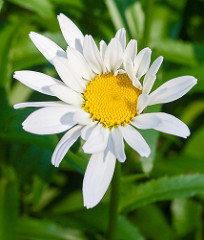

In [26]:
imageView(int(random.random() * len(imageslist)))

Image file: flowers/flower (25).jpg


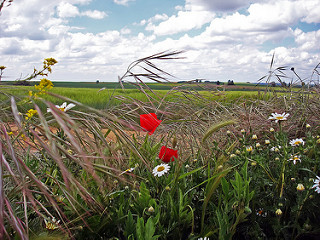

In [27]:
imageView(int(random.random() * len(imageslist)))

Image file: flowers/flower (471).jpg


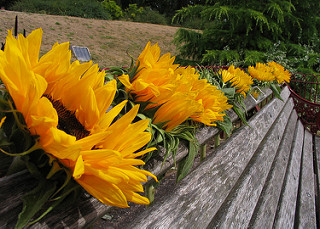

In [29]:
imageView(int(random.random() * len(imageslist)))

### Let's run the images clustering

In [30]:
nb_clusters = getImagesClusters(image_emb,
                                threshold=0.9,
                                min_cluster_size=20,
                                init_max_size=2745)

Computing images clusters...

Total number of clusters = 6

Done in 0.56 seconds


### Sounds like we have 6 classes of flowers images

In [32]:
print("Number of clusters =", nb_clusters)

Number of clusters = 6


In [33]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

Viewing images clustering results:

Cluster 1 = 241 images	 8.78 %
Cluster 2 = 199 images	 7.25 %
Cluster 3 = 180 images	 6.56 %
Cluster 4 = 102 images	 3.72 %
Cluster 5 = 87 images	 3.17 %
Cluster 6 = 31 images	 1.13 %


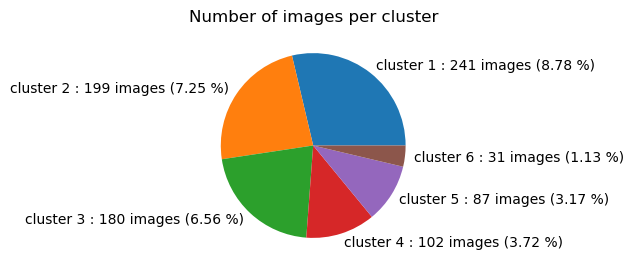


Total number of images in these clusters = 840 images 30.6 %

 ---------- Cluster number 1 size = 241 images ----------

Some images from this cluster:

Image filename: flowers/flower (1140).jpg


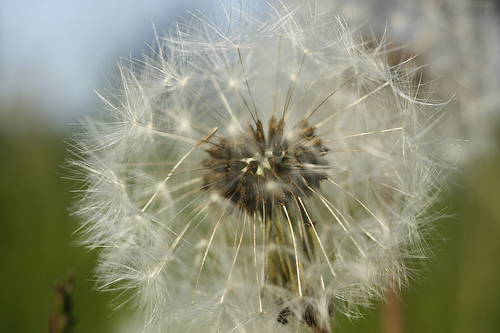

Image filename: flowers/flower (824).jpg


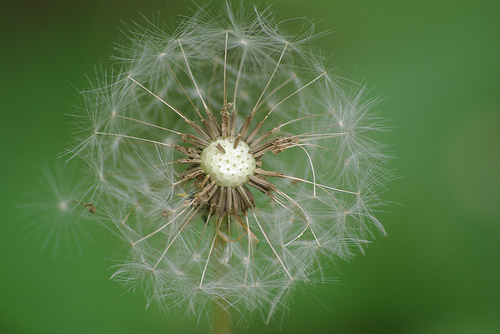

Image filename: flowers/flower (1441).jpg


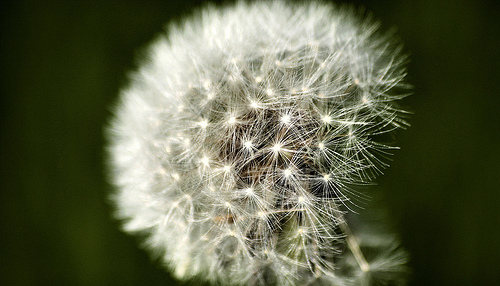

Image filename: flowers/flower (1530).jpg


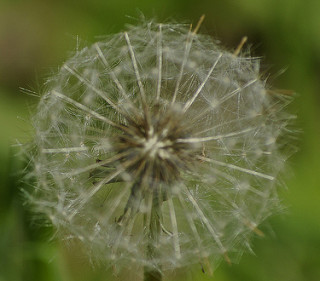

Image filename: flowers/flower (1639).jpg


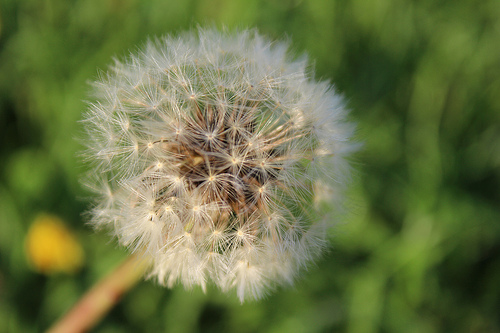

Image filename: flowers/flower (399).jpg


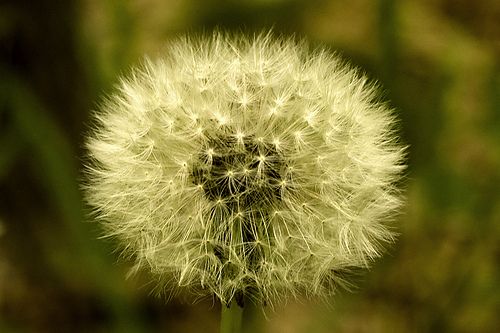


 ---------- Cluster number 2 size = 199 images ----------

Some images from this cluster:

Image filename: flowers/flower (1400).jpg


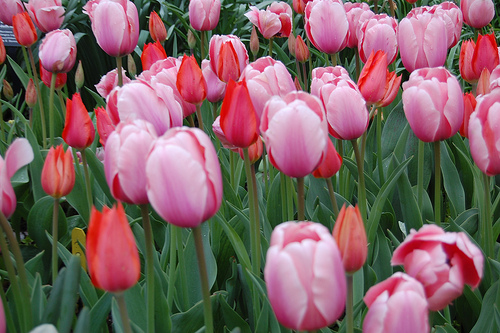

Image filename: flowers/flower (1416).jpg


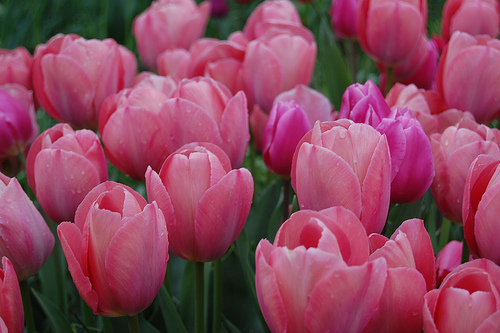

Image filename: flowers/flower (1418).jpg


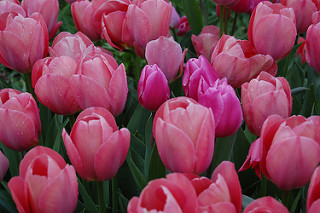

Image filename: flowers/flower (1403).jpg


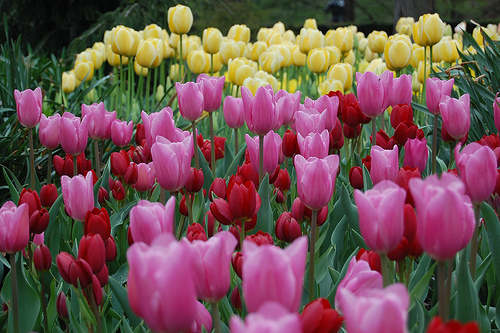

Image filename: flowers/flower (1417).jpg


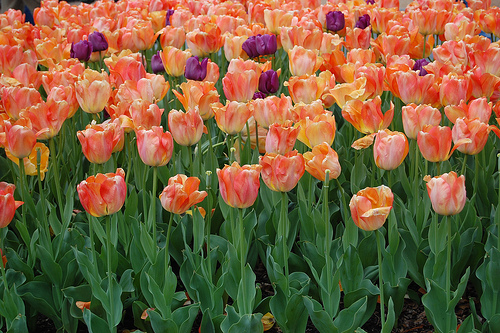

Image filename: flowers/flower (760).jpg


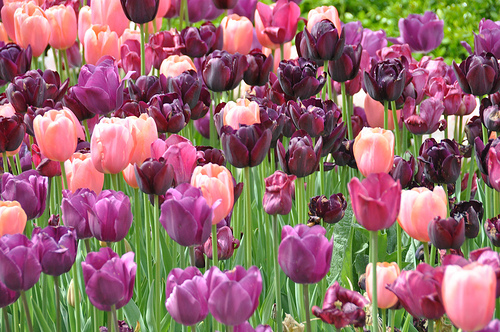


 ---------- Cluster number 3 size = 180 images ----------

Some images from this cluster:

Image filename: flowers/flower (761).jpg


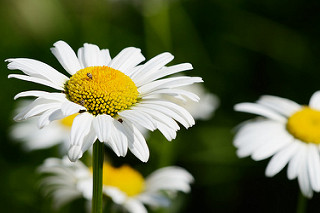

Image filename: flowers/flower (2056).jpg


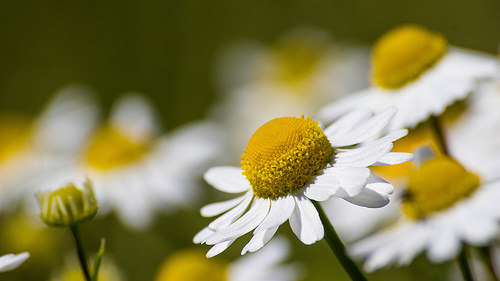

Image filename: flowers/flower (2079).jpg


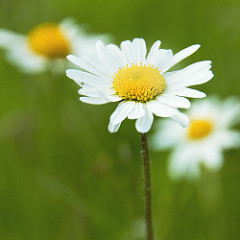

Image filename: flowers/flower (38).jpg


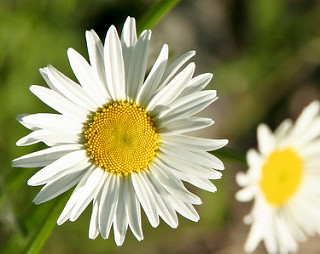

Image filename: flowers/flower (2388).jpg


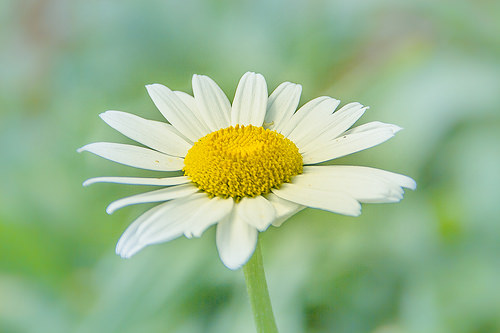

Image filename: flowers/flower (1252).jpg


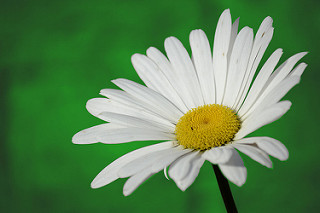


 ---------- Cluster number 4 size = 102 images ----------

Some images from this cluster:

Image filename: flowers/flower (2254).jpg


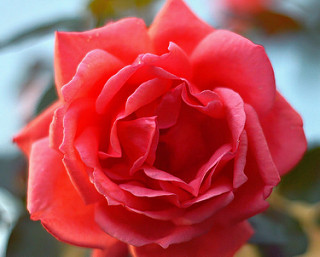

Image filename: flowers/flower (2571).jpg


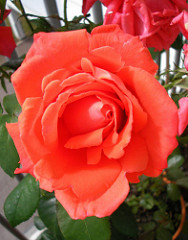

Image filename: flowers/flower (2160).jpg


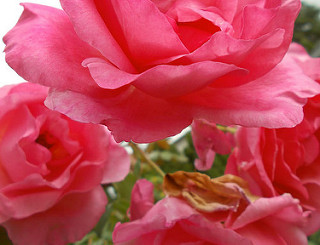

Image filename: flowers/flower (207).jpg


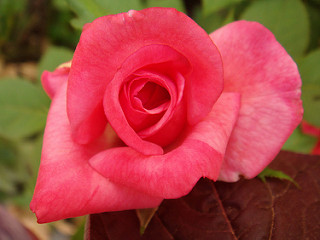

Image filename: flowers/flower (285).jpg


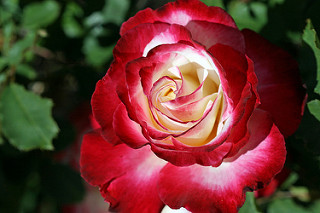

Image filename: flowers/flower (1168).jpg


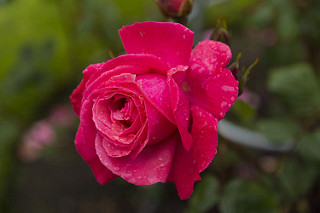


 ---------- Cluster number 5 size = 87 images ----------

Some images from this cluster:

Image filename: flowers/flower (919).jpg


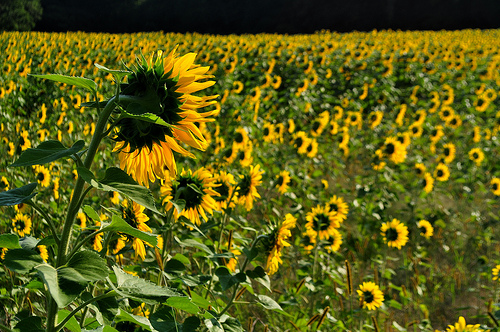

Image filename: flowers/flower (2044).jpg


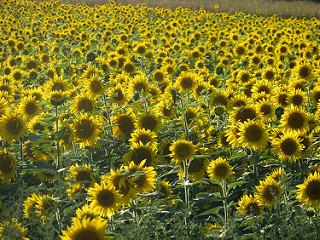

Image filename: flowers/flower (1657).jpg


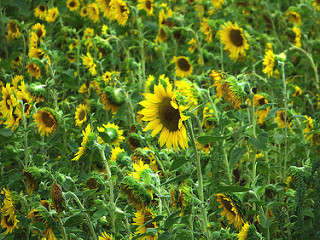

Image filename: flowers/flower (856).jpg


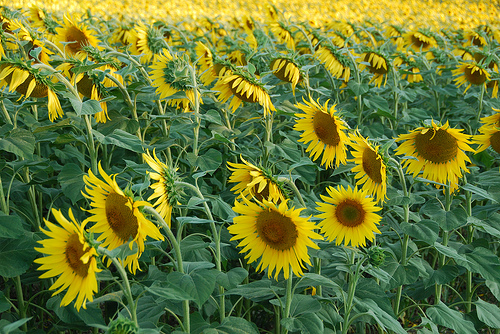

Image filename: flowers/flower (1645).jpg


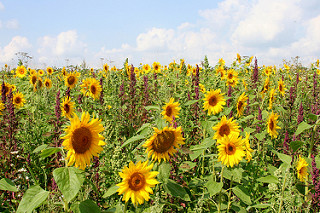

Image filename: flowers/flower (1496).jpg


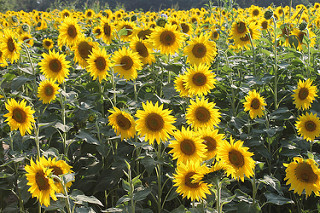


 ---------- Cluster number 6 size = 31 images ----------

Some images from this cluster:

Image filename: flowers/flower (2444).jpg


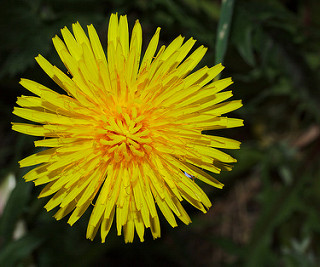

Image filename: flowers/flower (343).jpg


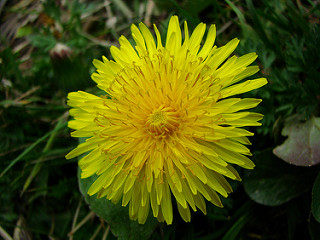

Image filename: flowers/flower (2566).jpg


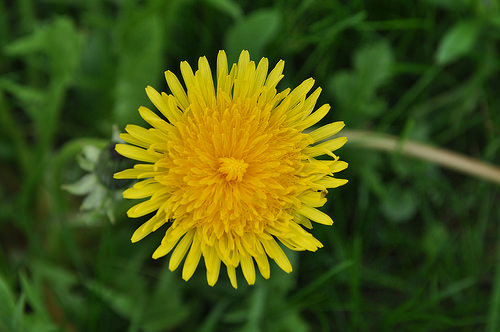

Image filename: flowers/flower (1360).jpg


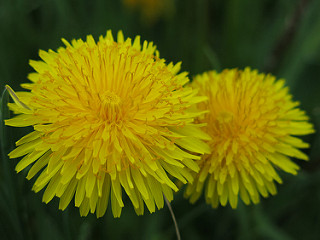

Image filename: flowers/flower (1435).jpg


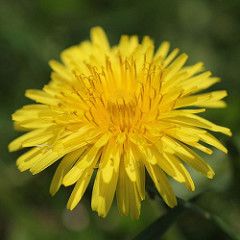

Image filename: flowers/flower (1470).jpg


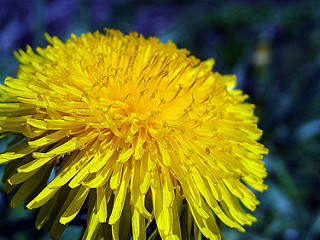

In [42]:
viewImagesClusters(nb_clusters, 6)

## 6. Let's do a visual search using our 6 flowers clusters (sun flower, dandelion, yellow dandelion, tulip, daisy & rose)

So it sounds like we have 6 families of flowers. 
We can use Open AI Clip capabilities for visual search using a query text. Let's define a list of the 6 clusters names we defined before and run a visual search

In [35]:
flower_families = [
    "sun flower", "white dandelion", "yellow dandelion", "tulip", "daisy",
    "rose"
]

In [38]:
flower_families

['sun flower', 'white dandelion', 'yellow dandelion', 'tulip', 'daisy', 'rose']

In [39]:
def visualSearch(query, topn=3, size=200):
    """
    Running a visual search
    """
    query_emb = model.encode([query],
                             convert_to_tensor=True,
                             show_progress_bar=False)

    results = util.semantic_search(query_emb, image_emb, top_k=topn)[0]

    print("\033[1;31;34mYour query:", query)
    print("\nResults:\n")

    idx = 1

    for result in results:
        print("\033[1;31;34m", idx, "- Catalog image ID:",
              imageslist[result['corpus_id']], "\n")
        display(IPDImage(imageslist[result['corpus_id']], width=size))
        
        idx += 1

### Let's run a visual search for the 6 clusters names

Some images search for cluster: sun flower 

Your query: sun flower

Results:

 1 - Catalog image ID: flowers/flower (1772).jpg 



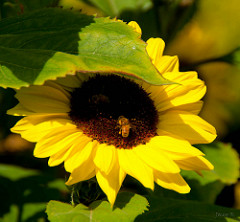

 2 - Catalog image ID: flowers/flower (1795).jpg 



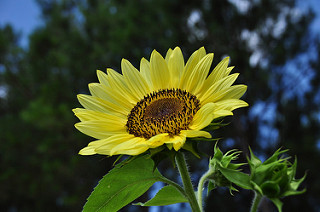

 3 - Catalog image ID: flowers/flower (617).jpg 



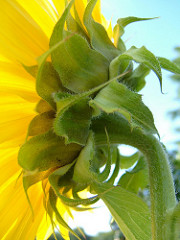

Some images search for cluster: white dandelion 

Your query: white dandelion

Results:

 1 - Catalog image ID: flowers/flower (1550).jpg 



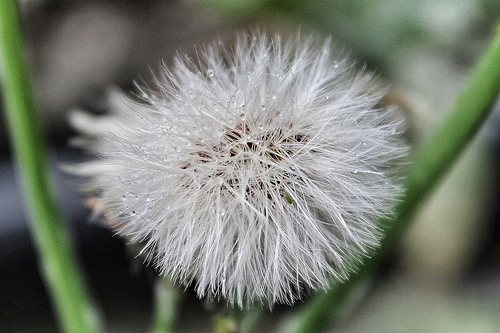

 2 - Catalog image ID: flowers/flower (1665).jpg 



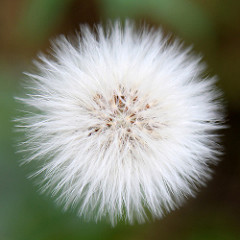

 3 - Catalog image ID: flowers/flower (1848).jpg 



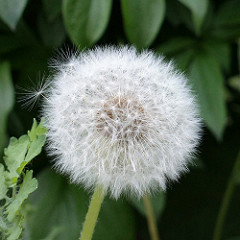

Some images search for cluster: yellow dandelion 

Your query: yellow dandelion

Results:

 1 - Catalog image ID: flowers/flower (323).jpg 



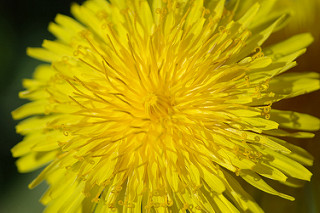

 2 - Catalog image ID: flowers/flower (702).jpg 



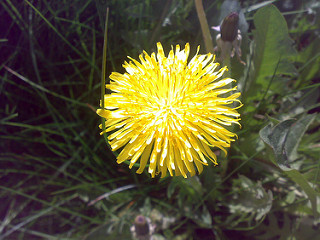

 3 - Catalog image ID: flowers/flower (2444).jpg 



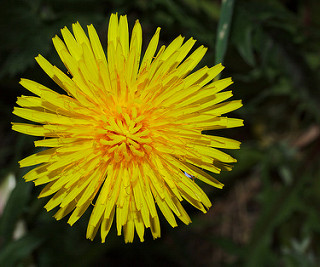

Some images search for cluster: tulip 

Your query: tulip

Results:

 1 - Catalog image ID: flowers/flower (2025).jpg 



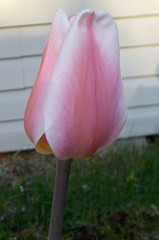

 2 - Catalog image ID: flowers/flower (2027).jpg 



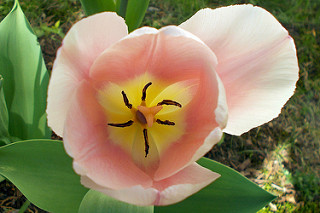

 3 - Catalog image ID: flowers/flower (1404).jpg 



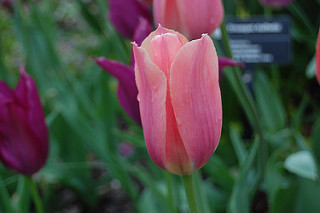

Some images search for cluster: daisy 

Your query: daisy

Results:

 1 - Catalog image ID: flowers/flower (2608).jpg 



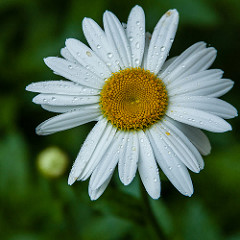

 2 - Catalog image ID: flowers/flower (872).jpg 



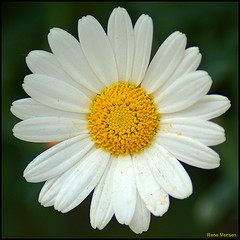

 3 - Catalog image ID: flowers/flower (2568).jpg 



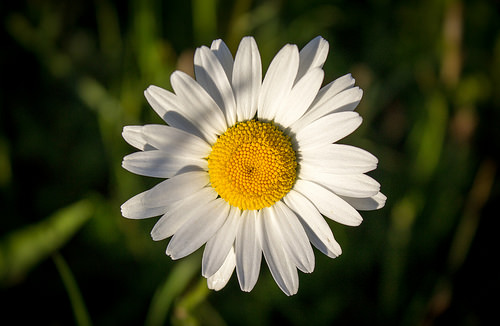

Some images search for cluster: rose 

Your query: rose

Results:

 1 - Catalog image ID: flowers/flower (1754).jpg 



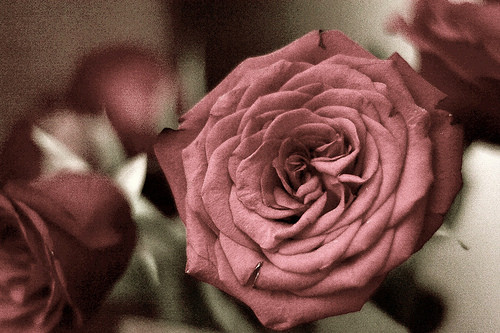

 2 - Catalog image ID: flowers/flower (1240).jpg 



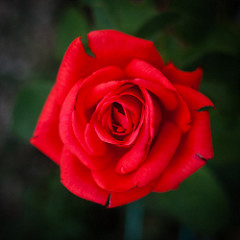

 3 - Catalog image ID: flowers/flower (2129).jpg 



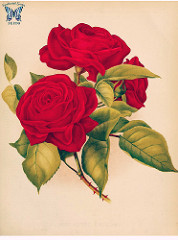

CPU times: user 1.39 s, sys: 53.6 ms, total: 1.44 s
Wall time: 1.08 s


In [40]:
%%time

for flower_family in flower_families:
    print("\033[1;31;32mSome images search for cluster:", flower_family, "\n")
    visualSearch(flower_family)